In [1]:
import sys
import os
import struct
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

fpX = np.float32

import torch 
root = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(os.path.join(root, 'code'))
from plotting import plot_utils, summary_plots, load_fits
plot_utils.set_plotting_defaults()
from utils import roi_utils, nsd_utils, default_paths

In [2]:
# Load results of the fitting procedure

subject = 1
volume_space=True
fitting_type = 'sketch_tokens'

root = os.path.dirname(os.path.dirname(os.getcwd()))
out, fig_save_folder = load_fits.load_fit_results(subject, volume_space, fitting_type, n_from_end=0, root=root, verbose=True)
load_fits.print_output_summary(out)

if not os.path.exists(fig_save_folder):
    os.makedirs(fig_save_folder)

loading from /user_data/mmhender/imStat/model_fits/S01/sketch_tokens/Oct-18-2021_1719_32/all_fit_params

dict_keys(['subject', 'volume_space', 'fitting_type', 'voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'aperture', 'aperture_rf_range', 'models', 'n_prf_sd_out', 'best_losses', 'best_lambdas', 'best_params', 'lambdas', 'val_cc', 'val_r2', 'partial_masks', 'partial_version_names', 'stack_result', 'stack_result_lo', 'partial_models_used_for_stack', 'train_r2', 'train_cc', 'zscore_features', 'zscore_in_groups', 'ridge', 'debug', 'up_to_sess', 'shuff_rnd_seed', 'use_precomputed_prfs', 'pop_recs', 'voxel_recs', 'min_pct_var', 'max_pc_to_retain', 'use_pca_st_feats', 'use_lda_st_feats', 'lda_discrim_type'])
subject = 1
volume_space = 1
fitting_type = sketch_tokens
voxel_mask: shape (699192,)
brain_nii_shape: shape (3,)
image_order: shape (7500,)
voxel_index: len 1
voxel_roi: len 4
voxel_ncsnr: shape (699192,)
aperture = 1.0
aperture_rf_range = 1.1


In [3]:
recon_corrcoef, sem_proj_slope, sem_proj_inter, sem_proj_r2, \
                    recon_sem_proj, actual_sem_proj, axes_to_do = out['voxel_recs']
recon_corrcoef = np.nan_to_num(recon_corrcoef)
pop_recons, pop_recon_r2, pop_recon_corrcoef, pop_recon_angle = out['pop_recs']
pop_recon_corrcoef = np.nan_to_num(pop_recon_corrcoef)

In [5]:
roi_def = roi_utils.get_combined_rois(subject,include_all=True,include_body=True,volume_space=True,verbose=False) 
skip_inds = [10,11,15,23]
retlabs, facelabs, placelabs, bodylabs, \
        ret_names, face_names, place_names, body_names = roi_def


In [6]:
axes2do = axes_to_do
maps = [np.mean(recon_corrcoef, axis=0)]
maps += [sem_proj_slope[:,aa] for aa in range(len(axes2do))]
maps += [sem_proj_r2[:,aa] for aa in range(len(axes2do))]

names = ['average single-trial reconstruction corr coef']
names += ['slope for recon/actual project onto %s'%axes2do[aa] for aa in range(len(axes2do))]
names += ['r2 for recon/actual project onto %s'%axes2do[aa] for aa in range(len(axes2do))]

cmaps = ['PuBu' for aa in range(len(maps))]
mins = [np.min(m) for m in maps]
maxes = [np.max(m) for m in maps]

plot_utils.plot_maps_pycortex(maps, names, subject, out, fitting_type, port=33333, roi_def=roi_def, \
                       mins=mins, maxes=maxes, cmaps=cmaps)

Data is in 3d volume space
navigate browser to: 127.0.0.1:33333
Started server on port 33333


In [7]:

sessions = np.arange(out['up_to_sess'])
image_order = nsd_utils.get_master_image_order()
session_inds = nsd_utils.get_session_inds_full()
sessions = np.array(sessions)
inds2use = np.isin(session_inds, sessions)
image_order = image_order[inds2use]
shared_1000_inds = image_order<1000
image_order_val = image_order[shared_1000_inds]
image_order_trn = image_order[~shared_1000_inds]


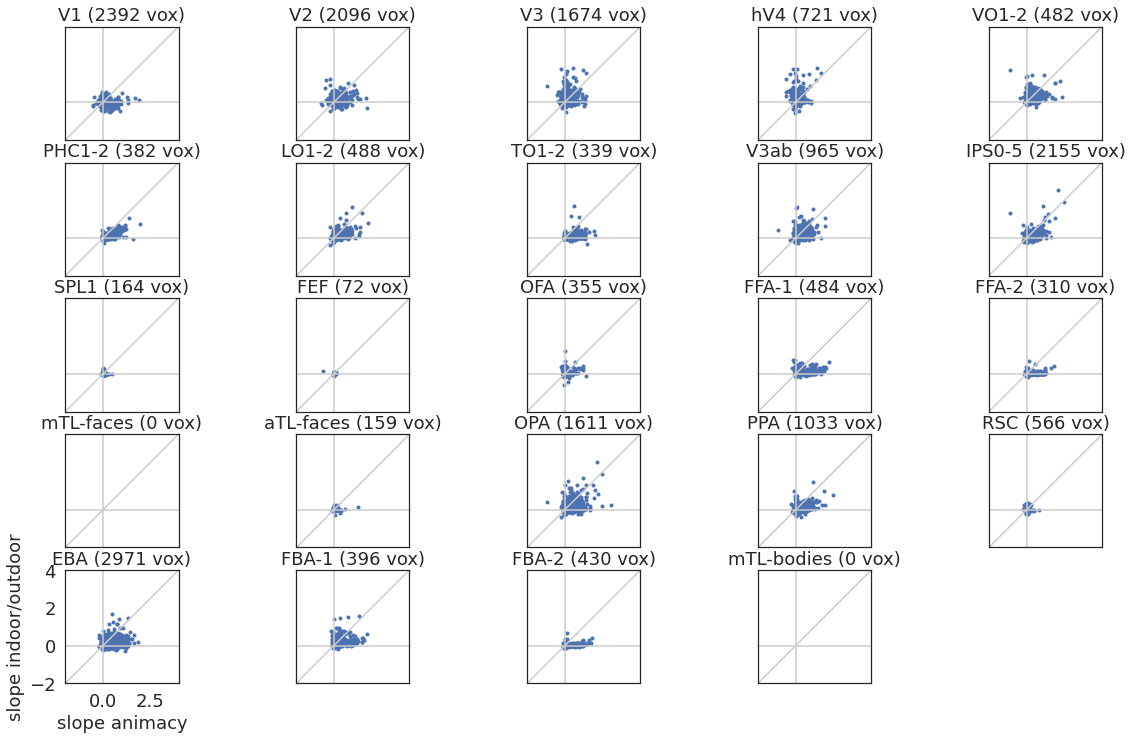

In [8]:

plot_utils.set_all_font_sizes(fs = 18)
fig_size=(20,24)

xdat = sem_proj_slope[:,0]
ydat = sem_proj_slope[:,1]

inds2use = np.ones((np.shape(xdat)[0],))==1

sp = plot_utils.scatter_plot(color=None, xlabel='slope animacy', ylabel='slope indoor/outdoor', \
                             xlims=[-2, 4], ylims=[-2,4],  xticks=None, yticks=None,\
                            show_diagonal=True, show_axes=True);

if fig_size is None:
    fig_size = (20,18)
plot_utils.create_roi_subplots(np.concatenate([xdat[:,np.newaxis],ydat[:,np.newaxis]], axis=1), \
                               inds2use, sp, subject, out, roi_def, \
                    suptitle=None,
                   label_just_corner=True, figsize=fig_size)
plt.gcf().subplots_adjust(bottom=0.5)


In [9]:
lda_result_list = []
sketch_token_feat_path = default_paths.sketch_token_feat_path
for aa, discrim_type in enumerate(axes_to_do):
    features_file = os.path.join(sketch_token_feat_path, 'LDA', \
                                              'S%d_LDA_%s.npy'%(subject, discrim_type))
    print('loading from %s'%features_file)
    lda_result = np.load(features_file, allow_pickle=True).item()
    lda_result_list.append(lda_result)


loading from /user_data/mmhender/features/sketch_tokens/LDA/S1_LDA_animacy.npy
loading from /user_data/mmhender/features/sketch_tokens/LDA/S1_LDA_indoor_outdoor.npy


9656
V1


Text(0.5, 1.0, 'voxel 9656, V1')

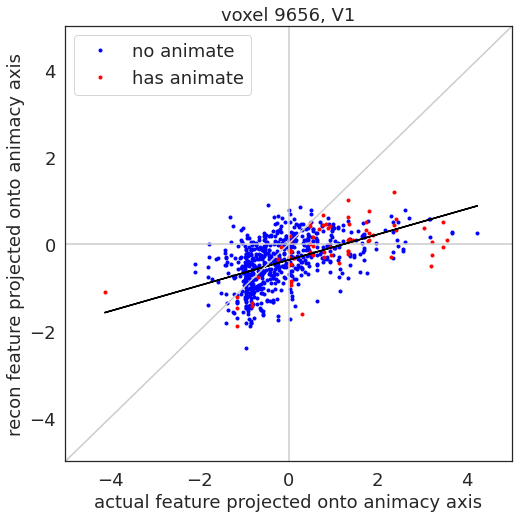

Stopping server


In [10]:
this_roi = np.where(retlabs==0)[0]
vind = np.argmax(out['val_cc'][retlabs==0,0])
vind = this_roi[vind]
print(vind)
name = np.array(ret_names)[int(retlabs[vind])] 
print(name)

aa = 0
mm = out['best_params'][5][vind,0]
labels = lda_result_list[aa]['labels_actual'][mm]
labels = labels[image_order_val]

lim=5
rec = recon_sem_proj[:,vind,aa]
act = actual_sem_proj[:,vind,aa]
slope = sem_proj_slope[vind,aa]
inter = sem_proj_inter[vind,aa]
rec_pred = act*slope + inter

plt.figure(figsize=(8,8));
lh1 = plt.plot(act[labels==0], rec[labels==0], '.',color='b')
lh2 = plt.plot(act[labels==1], rec[labels==1], '.',color='r')
plt.axhline(0, color=[0.8, 0.8, 0.8])
plt.axvline(0, color=[0.8, 0.8, 0.8])
plt.xlabel('actual feature projected onto animacy axis')
plt.ylabel('recon feature projected onto animacy axis')
plt.xlim([-lim, lim]);
plt.ylim([-lim, lim]);
plt.plot(act, rec_pred, color='k')
plt.plot([plt.gca().get_xlim()[0], plt.gca().get_xlim()[1]],\
         [plt.gca().get_ylim()[0], plt.gca().get_ylim()[1]], color=[0.8, 0.8, 0.8])
# plt.axis('square');
plt.legend([lh1[0], lh2[0]], ['no animate','has animate'])
plt.title('voxel %d, %s'%(vind, name))

13641
hV4


Text(0.5, 1.0, 'voxel 13641, hV4')

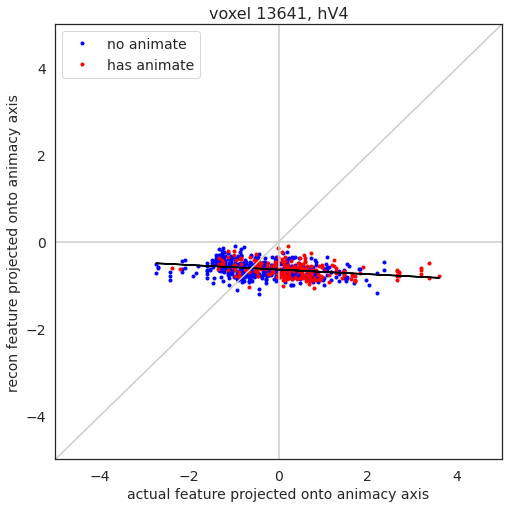

In [22]:
this_roi = np.where(retlabs==3)[0]
vind = np.argmax(out['val_cc'][this_roi,0])
vind = this_roi[vind]
print(vind)
name = np.array(ret_names)[int(retlabs[vind])] 
print(name)

aa = 0
mm = out['best_params'][5][vind,0]
labels = lda_result_list[aa]['labels_actual'][mm]
labels = labels[image_order_val]

lim=5
rec = recon_sem_proj[:,vind,aa]
act = actual_sem_proj[:,vind,aa]
slope = sem_proj_slope[vind,aa]
inter = sem_proj_inter[vind,aa]
rec_pred = act*slope + inter

plt.figure(figsize=(8,8));
lh1 = plt.plot(act[labels==0], rec[labels==0], '.',color='b')
lh2 = plt.plot(act[labels==1], rec[labels==1], '.',color='r')
plt.axhline(0, color=[0.8, 0.8, 0.8])
plt.axvline(0, color=[0.8, 0.8, 0.8])
plt.xlabel('actual feature projected onto animacy axis')
plt.ylabel('recon feature projected onto animacy axis')
plt.xlim([-lim, lim]);
plt.ylim([-lim, lim]);
plt.plot(act, rec_pred, color='k')
plt.plot([plt.gca().get_xlim()[0], plt.gca().get_xlim()[1]],\
         [plt.gca().get_ylim()[0], plt.gca().get_ylim()[1]], color=[0.8, 0.8, 0.8])
# plt.axis('square');
plt.legend([lh1[0], lh2[0]], ['no animate','has animate'])
plt.title('voxel %d, %s'%(vind, name))

13627
OPA


Text(0.5, 1.0, 'voxel 13627, OPA')

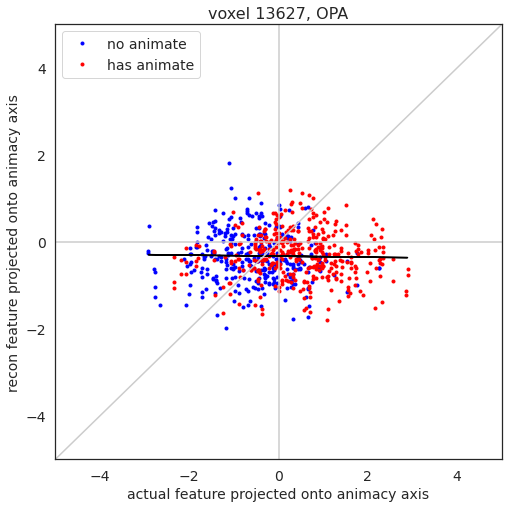

In [23]:
this_roi = np.where(placelabs==0)[0]
vind = np.argmax(out['val_cc'][placelabs==0,0])
# vind = np.argsort(sem_proj_slope[this_roi,0])[0]
vind = this_roi[vind]
print(vind)
name = np.array(place_names)[int(placelabs[vind])] 
print(name)

aa = 0
mm = out['best_params'][5][vind,0]
labels = lda_result_list[aa]['labels_actual'][mm]
labels = labels[image_order_val]

lim=5
rec = recon_sem_proj[:,vind,aa]
act = actual_sem_proj[:,vind,aa]
slope = sem_proj_slope[vind,aa]
inter = sem_proj_inter[vind,aa]
rec_pred = act*slope + inter

plt.figure(figsize=(8,8));
lh1 = plt.plot(act[labels==0], rec[labels==0], '.',color='b')
lh2 = plt.plot(act[labels==1], rec[labels==1], '.',color='r')
plt.axhline(0, color=[0.8, 0.8, 0.8])
plt.axvline(0, color=[0.8, 0.8, 0.8])
plt.xlabel('actual feature projected onto animacy axis')
plt.ylabel('recon feature projected onto animacy axis')
plt.xlim([-lim, lim]);
plt.ylim([-lim, lim]);
plt.plot(act, rec_pred, color='k')
plt.plot([plt.gca().get_xlim()[0], plt.gca().get_xlim()[1]],\
         [plt.gca().get_ylim()[0], plt.gca().get_ylim()[1]], color=[0.8, 0.8, 0.8])
# plt.axis('square');
plt.legend([lh1[0], lh2[0]], ['no animate','has animate'])
plt.title('voxel %d, %s'%(vind, name))

19259
EBA


Text(0.5, 1.0, 'voxel 19259, EBA')

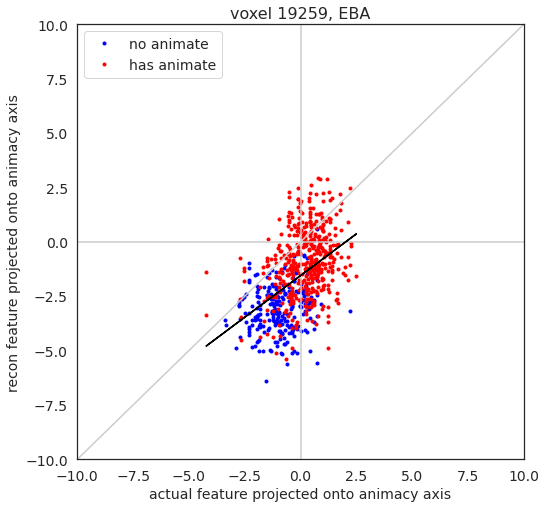

In [24]:
this_roi = np.where(bodylabs==0)[0]
vind = np.argmax(out['val_cc'][this_roi,0])
# vind = np.argsort(sem_proj_slope[this_roi,0])[0]
vind = this_roi[vind]
print(vind)
name = np.array(body_names)[int(bodylabs[vind])] 
print(name)

aa = 0
mm = out['best_params'][5][vind,0]
labels = lda_result_list[aa]['labels_actual'][mm]
labels = labels[image_order_val]

lim=10
rec = recon_sem_proj[:,vind,aa]
act = actual_sem_proj[:,vind,aa]
slope = sem_proj_slope[vind,aa]
inter = sem_proj_inter[vind,aa]
rec_pred = act*slope + inter

plt.figure(figsize=(8,8));
lh1 = plt.plot(act[labels==0], rec[labels==0], '.',color='b')
lh2 = plt.plot(act[labels==1], rec[labels==1], '.',color='r')
plt.axhline(0, color=[0.8, 0.8, 0.8])
plt.axvline(0, color=[0.8, 0.8, 0.8])
plt.xlabel('actual feature projected onto animacy axis')
plt.ylabel('recon feature projected onto animacy axis')
plt.xlim([-lim, lim]);
plt.ylim([-lim, lim]);
plt.plot(act, rec_pred, color='k')
plt.plot([plt.gca().get_xlim()[0], plt.gca().get_xlim()[1]],\
         [plt.gca().get_ylim()[0], plt.gca().get_ylim()[1]], color=[0.8, 0.8, 0.8])
# plt.axis('square');
plt.legend([lh1[0], lh2[0]], ['no animate','has animate'])
plt.title('voxel %d, %s'%(vind, name))

In [95]:
a = act
b = rec
a = np.concatenate([a[:,np.newaxis], np.ones((np.shape(a)[0],1))], axis=1)
x = np.linalg.pinv(a) @ b

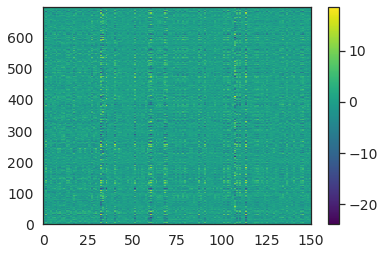

In [26]:
plt.figure();
plt.pcolormesh(pop_recons[:,:,0])
plt.colorbar()